## EEG Analysis: Epilepsy in pediatric patients

### Background
In this notebook we will be analyzing data of pediatric patients with epilepsy. This data is of free acces and can be downloaded from https://openneuro.org/datasets/ds003555/versions/1.0.1/download. The dataset of EEG recordings contains HFO markings for 30 pediatric patients with epilepsy. All the recordings were made with the 10-20 system.

Our objective is to create an algorithm able to detect when an epileptic attack occurs. We know that epileptic seizures occur mostly during the N2 and N3 sleep stages. So the first step would be to be able to divide the recordings in sleep stages

Altought the divition of may vary among different authors, we are able to make a correlation of stages basen on the description of each. Here we will work with the following stages: Awake, N1, N2, N3, REM. This convention is preffered because the data we will use is already marked with those stages, so validation will be easier.  

Brain activity is usually classified by frequency. There are 5 main types of waves: delta, theta, alpha, beta and gamma, with delta being the one with the lowest frequency and gamma the one with the highest frequency. In the following table we have a summary of how every type of wave is involved in a given sleep stage. 


<table>
<tr>
<td> </td>
<td>Delta waves: 0.2-4 Hz</td>
<td>Theta waves: 4-8 Hz</td>
<td>Alpha waves: 8-12 Hz</td>
<td>Beta waves: 12-30 Hz</td>
</tr>
<tr>
<td>Awake</td>
  <td> </td>  
<td> </td>
<td>Dominant rhythm over the occipital regions</td>
    <td>Main component in anterior leads</td>
</tr>
    <tr>
<td>N1</td>
        <td> </td>
        <td> Main activity</td>
<td>Disappearance of the alpha rhythm</td>
        <td> </td>
</tr>   
    <tr>
<td>N2</td>
<td> </td>
        <td>Bilaterally synchronous theta activity</td>
        <td> </td>
        <td> Sleep spindles or k waves may appear </td>
</tr>   
    <tr>
<td>N3</td>
<td>Slow Delta waves</td>
        <td> </td>
        <td> </td>
        <td> K-complexes and sleep spindles may be present</td>
</tr>   
    <tr>
<td>REM</td>
<td> </td>
        <td>Sawtooth waves are seen (2-6 Hz)</td>
<td>Similar to N1 activity</td>
<td> </td>
</tr>   
</table>

Information obtained from 3, 4, 5.

Notice that the gamma waves were not included. This is because gamma waves are moslty indicators that the suject is conscious and on high alert, so they are not normal in a sleep EEG, however they could be an indicator of muscle activity, so they are important, particularly in the frontal electrodes. Eye movement is characteristic in REM sleep and it can be observed in the electrodes F7 and F8.

![](REM.png)

Image obtained from: The Normal Asleep EEG. (2022, July 13). Retrieved from https://www.learningeeg.com/normal-asleep#top

### Sleep spindles

Sleep spindles are symetric bursts of activity of 12-14 Hz that last a cuple of secconds. In the analysis of the EEG we would expect to see a biphasic PSD with an increase in the 12-14 Hz components. 

![Spindles.png](Spindles.png)

Image obtained from: The Normal Asleep EEG. (2022, July 13). Retrieved from https://www.learningeeg.com/normal-asleep#top

### K-waves

![](K_complex.png)
Image obtained from: The Normal Asleep EEG. (2022, July 13). Retrieved from https://www.learningeeg.com/normal-asleep#top

### About the 10-20 system 

The letters on the electrodes represent the general areas of the brain that are covered by the electrodes. From front to back, the electrodes are labeled as follows: Fp (prefrontal cortex or frontal pole), F (frontal), C (centerline of the brain), T (temporal), P (parietal), and O (Back of the head). ). The electrodes between these rows are a combination of several letters placed from front to back. This applies to high density systems. 

In addition, the letters M and A may be used to refer to the mastoid process and earlobe, respectively. These locations are typically recorded to serve as  (offline) references for signal analysis. The 
 electrode number provides information about the distance from the electrode to the median plane of the brain. At the median, the electrodes are marked with a "z" to represent zero. The number of electrodes increases as you move away from the centerline. Odd numbers represent the electrodes in the left hemisphere, and even numbers represent the electrodes in the right hemisphere. 
 
Accurate results can only be obtained if the head cap is placed correctly. H. When the electrodes cover the desired location on the scalp. Therefore, it is important to choose the correct size head cap and make sure that Cz is  between the nasion and inion and the two congenital eyelid points.

![](10-20_system.png)

## Similar studies
A study made by the univertsity of Texas intended to extract parameters from EEG recordings that were relevant for sleep stage classification(Estrada, 2004). They found that harmonic parameters as well as spectral density values could help the classification. The best paramereters were the Intakura distance adn a version of the Hjord parameters. 

Another paper written by the Ghent University Hospital in Belgum used cluster analysis to predict the sleep stage of EEG recordings (VanHese, 2001). In this studies 3 types of parameters were used: 
* Parameterers of Hjorth
* Harmonic parameters
* Relative band energy

They found that these 3 sets of parameters were enough to classify a 10 second segment into a sleep stage. 

Finaly, a study made by the University of Southern Queensland in Australia trained complex networks to clasify EEG recordings into sleep stages(Diykh, 2016). In this study, several machine learning structures were used including a decision tree, a support vector machine, a linear discrimination and a k-mean clustering algorithm. Among all of these, the one that proved to be more accurate was the k-means clustering along with a complex netowrk for parameter extraction. 

## Suggested aproach
The first objective is to extract valuable parameters from the recordings. Each recording lasts 3 hours and has 23 channels. The fisrt step is to split the data according to sleep phase. It is important to consider that each of the NREM phases are a process with differences that gradually appear. So, in order to avoid borderline effects we will leave out cushions at the beginning and at the end of each phase.

Then, each segment will be splitted into subsegments of 15 s. A set of hermonic properties will then be extracted from each sub-segment


### Importing the packagery 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib qt
import scipy as sp
import mne
import seaborn as sns
from scipy.signal import welch, butter,lfilter, filtfilt, freqs

### How to import data

In [2]:
# Subject ID
sub=3
# Segment to be imported
run=1


sub_str="0"+str(sub)
run_str="0"+str(run)
sub=sub_str[-2:]
run=run_str[-2:]

In [3]:
# Import data from path
raw=mne.io.read_raw_edf("sub-"+sub+"/ses-01/eeg/sub-"+sub+"_ses-01_task-hfo_eeg.edf", preload=True, verbose=0)

Effective window size : 2.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min finished


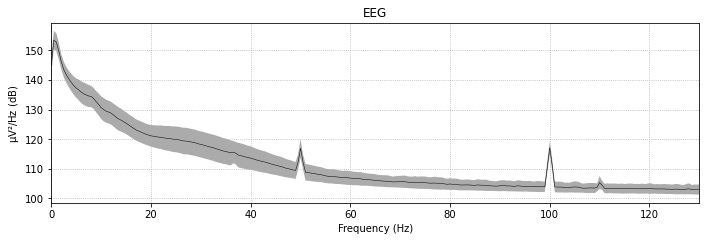

In [4]:
#Plot PSD of the data
fig = raw.plot_psd(fmax=130, average=True)

As we can see there are spikes of noise at 50 Hz and 100 Hz. This is caused by the frequency of the power input to the electrode system. This type of noise is more frequently found at 60 Hz in studies made in the US, Mexico and other american countries. In european studies however it is more common to find 50 Hz noise. 

Since the filtering process is not part of this proyects objetives it will only be lightly explained, however detailes information on the process may be found in the MNE documentation(https://mne.tools/stable/auto_tutorials/preprocessing/25_background_filtering.html#disc-filtering).

The filtering process consists of convolution filter that is applied on the original data array and the filtered data array. This means that a filtered value is a wheighted average of the previous unfiltered values and the previous filtered values. The wheights are calculated from a transfer funtion in the frequency domain H(z). The mne filtering function automatically calculates the optimal lenght of the convolution window and the coefficients for the desired frequency cutoff. 

In this case we are only intrested in the frequencies between 0.2 Hz and 90 Hz. Since we want this values to be the cutoff frequency, the passband edges will be 0.4 Hz and 80 Hz. 

In [5]:
# Band pass filter
raw.filter(0.4, 80)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.4 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 8449 samples (8.251 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    8.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:  1.5min finished


<RawEDF | sub-03_ses-01_task-hfo_eeg.edf, 23 x 11059200 (10800.0 s), ~1.90 GB, data loaded>

Now we will remove the 50 Hz noise. We must remember that it is important to apply a band stop filter at the main frequency AND its multiples. In this case we only need to apply 2 notch filters at 50 Hz and 100 Hz.

In [6]:
# Notch filter to remove 50 Hz noise
raw.notch_filter([50,100])

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   12.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:  2.4min finished


<RawEDF | sub-03_ses-01_task-hfo_eeg.edf, 23 x 11059200 (10800.0 s), ~1.90 GB, data loaded>

Effective window size : 2.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min finished


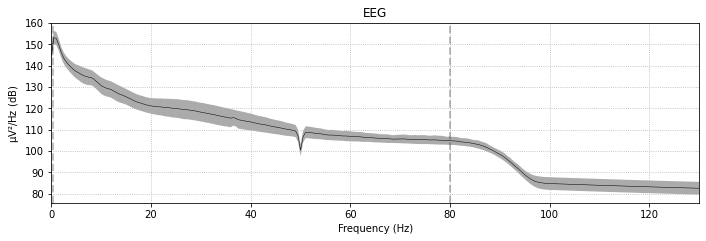

In [7]:
# PSD after filtering
fig = raw.plot_psd(fmax=130, average=True)

### Frontal vs central vs parietal electrodes

Effective window size : 2.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.4s finished


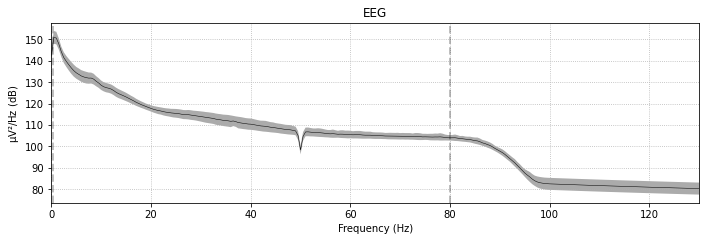

In [8]:
#Plot PSD of the data
fig = raw.plot_psd(fmax=130, average=True, picks=["Fp1","Fp2","F3","F4","F7","F8","Fz"])

Effective window size : 2.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s finished


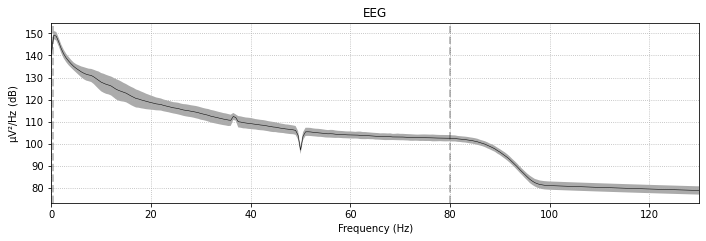

In [9]:
#Plot PSD of the data
fig = raw.plot_psd(fmax=130, average=True, picks=["C3","Cz","C4"])

Effective window size : 2.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s finished


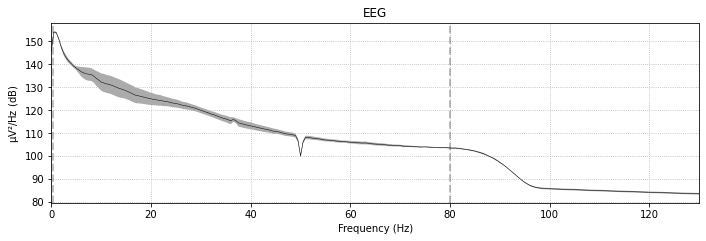

In [10]:
#Plot PSD of the data
fig = raw.plot_psd(fmax=130, average=True, picks=["P3","Pz","P4"])

In the last 3 PSDs it can be observed that the central electrodes don't share a general shape of spectral density with the frontal electrodes nor with the parietal electrodes. This means that even though the central electrodes don't correspond to a cerebral lobe, they should be treated as independent.

### Loading the data

By default, MNE does not load data into main memory to conserve resources. inst.filter requires raw data to be loaded.

In [11]:
# Extract the data
data = raw._data
fs = int(raw.info['sfreq'])
chan = raw.ch_names

# Let's have a look at the data
print('Chan =', chan)
print('Sampling frequency =', fs, 'Hz')
print('Data shape =', data.shape)

Chan = ['Fp1', 'A2', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'A1', 'O2', 'T1', 'T2']
Sampling frequency = 1024 Hz
Data shape = (23, 11059200)


In [12]:
# Load the events data
events=pd.read_csv("derivatives/sub-"+sub+"/ses-01/eeg/sub-"+sub+"_ses-01_task-hfo_run-"+run+"_events.tsv",sep="\t")

In [13]:
events

nChannel strChannelName  indStart  indStop  indDuration  Event_RMS  \
0           1        Fp1-Fp2    171777   171861           84   5.933874   
1           1        Fp1-Fp2    478079   478147           68   9.489360   
2           1        Fp1-Fp2    478264   478351           87   8.365235   
3           1        Fp1-Fp2    478431   478525           94   6.740478   
4           1        Fp1-Fp2    479181   479239           58   4.905034   
..        ...            ...       ...      ...          ...        ...   
282        51          T4-F4     95923    95983           60   5.776741   
283        51          T4-F4    203353   203446           93   5.798611   
284        51          T4-F4    335243   335305           62   6.073245   
285        51          T4-F4    481746   481820           74   4.791709   
286        51          T4-F4    487179   487234           55   3.764801   

     Window_RMS  EventPeak2Peak       SNR     Amplpp  PowerTrough  Ftrough  \
0      3.362942       20.938139  3.113422  37.437634     0.959410     86.0   
1      4.763889       32.944284  4.686149  40.786933     1.188129     93.0   
2      4.894383       36.389311  3.457903  40.786933     3.832971     83.0   
3      5.204053       26.565367  2.110070  40.786933     1.446160    120.0   
4      4.743556       16.438231  1.355520  38.556055     1.161556    100.0   
..          ...             ...       ...        ...          ...      ...   
282    2.196614       20.073272  6.916056  20.073272     0.902945    118.0   
283    2.097479       22.007932  7.642803  22.007932     0.423949    112.0   
284    2.190029       23.875211  7.690277  23.875211     1.105948    120.0   
285    2.502176       15.804761  3.667289  18.315251     0.789778    158.0   
286    2.265691       11.717692  2.761105  21.349461     0.470870    177.0   

     PowmaxFR  fmax_FR  EvPassRejection  
0    3.728072       85                0  
1    1.156296       92                0  
2    4.345715       82                0  
3    2.703719      119                0  
4    1.261460       99                0  
..        ...      ...              ...  
282  3.187190      117                1  
283  0.757264      111                1  
284  1.889742      119                1  
285  2.674127      157                0  
286  2.159051      178                0  

[287 rows x 15 columns]

Note that the events are given with the channel names of the derivatives and the indexes correspond to the sampling frequency of the derivative resamling at 2 000 Hz. 

In [14]:
# Load the intervals metadata
intervals=pd.read_csv("derivatives/sub-"+sub+"/ses-01/eeg/DataIntervals.tsv",sep="\t")

In [15]:
intervals

StartInd    EndInd SleepStage  RunNb
0     178270    485470         N3      1
1     485470    792670         N3      2
2     792670   1099870         N3      3
3    1099870   1407070         N3      4
4    1407070   1714270         N3      5
5    1714270   2021470         N3      6
6    2021470   2328670         N3      7
7    2328670   2635870         N3      8
8    2635870   2943070         N3      9
9    2943070   3250270         N3     10
10   3415548   3722748        REM      0
11   3722748   4029948        REM      0
12   4184698   4491898         N2      0
13   4491898   4799098         N2      0
14   4799098   5106298         N2      0
15   5106298   5413498         N2      0
16   5413498   5720698         N2      0
17   5720698   6027898         N2      0
18   6027898   6335098         N2      0
19   6493262   6800462         N3     11
20   6800462   7107662         N3     12
21   7107662   7414862         N3     13
22   7414862   7722062         N3     14
23   7722062   8029262         N3     15
24   8029262   8336462         N3     16
25   8336462   8643662         N3     17
26   8643662   8950862         N3     18
27   9223497   9530697        REM      0
28   9530697   9837897        REM      0
29   9837897  10145097        REM      0
30  10145097  10452297        REM      0
31  10731384  11038584         N2      0

In [16]:
subjects=pd.read_csv("participants.tsv",sep="\t")

In [17]:
#n: Number of chanels
#N: lenght of the recording 
n,N=data.shape

In [18]:
#tf: Lenght of the recording in time
tf=N/fs

In [19]:
#Time array
time_arr=np.linspace(0,tf,num=N)

In [20]:
#i_s: Start index
#i_e: End index
i_s=intervals[intervals["RunNb"]==int(run)].iloc[0]["StartInd"]
i_e=intervals[intervals["RunNb"]==int(run)].iloc[0]["EndInd"]

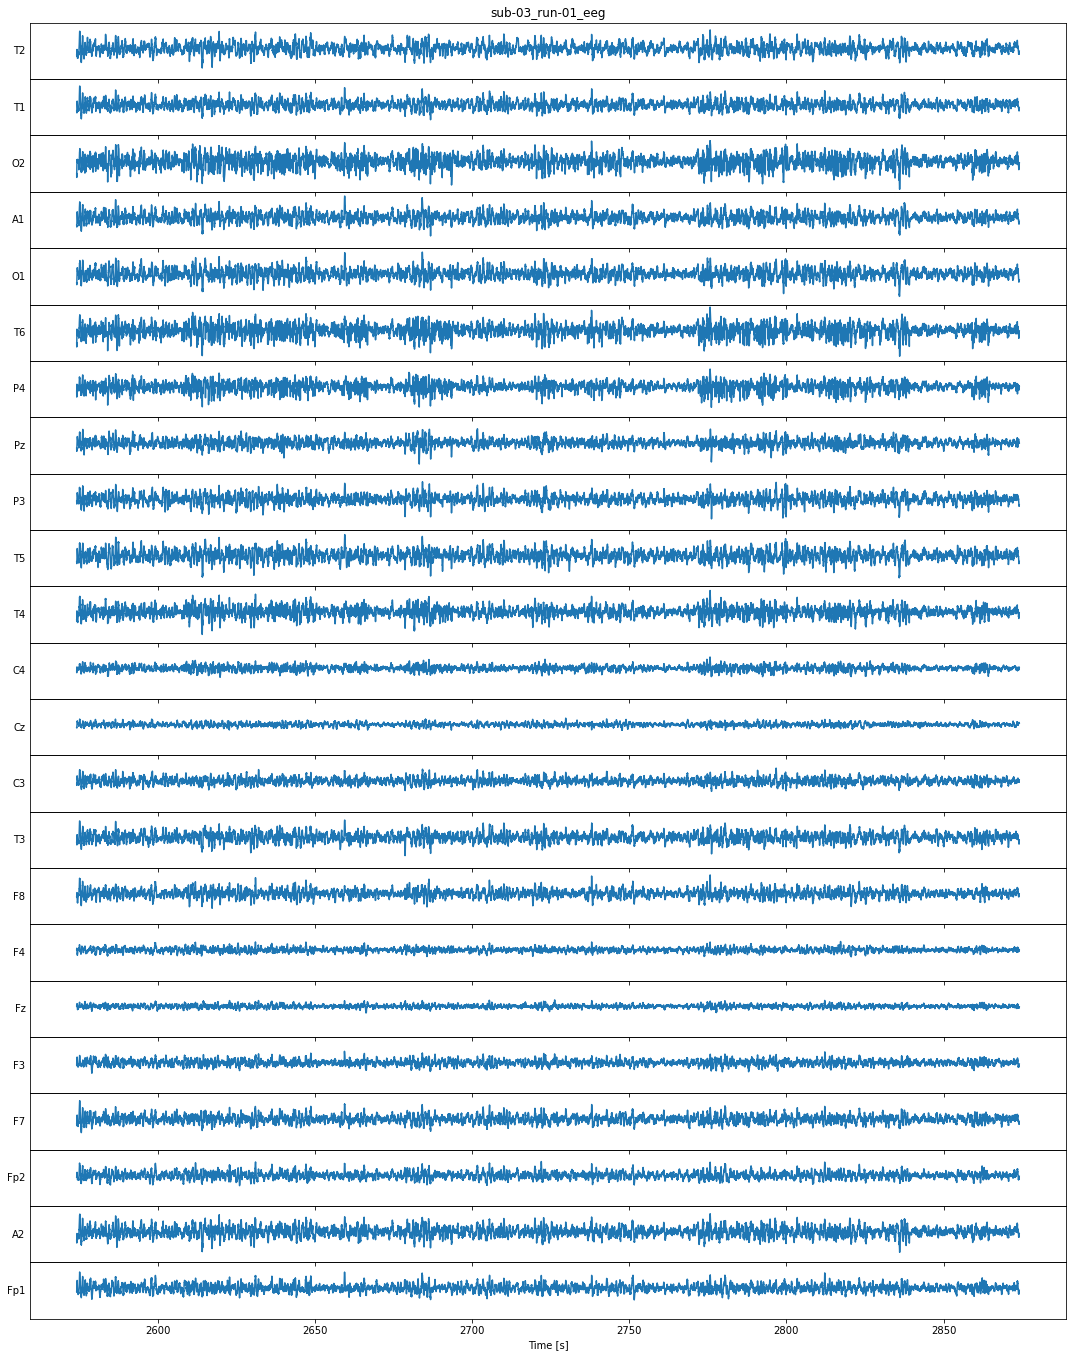

In [60]:
# Plot the first segment of data
i_i=i_s
i_f=i_e
fig=plt.figure(figsize=(18,18))
count=0.0
axlist = []
yprops = dict(rotation=0, horizontalalignment='right', verticalalignment='center')
axprops = dict(yticks=[])
for i in range(0,n):
    ax = fig.add_axes([0.1, count, 0.8, 1/n], **axprops)
    axlist.append(ax)
    axprops['sharex'] = ax
    axprops['sharey'] = ax
    ax.plot(time_arr[i_i:i_f],data[i,i_i:i_f])
    ax.set_ylabel(chan[i], **yprops)
    count+=1/n
    if i==0:
        plt.xlabel("Time [s]")
for ax in axlist[1:]:
    plt.setp(ax.get_xticklabels(), visible=False)
plt.title("sub-"+sub+"_run-"+run+"_eeg")
plt.show();

### Events

In [22]:
i_s=intervals.iloc[8]["StartInd"]
i_e=intervals.iloc[8]["EndInd"]

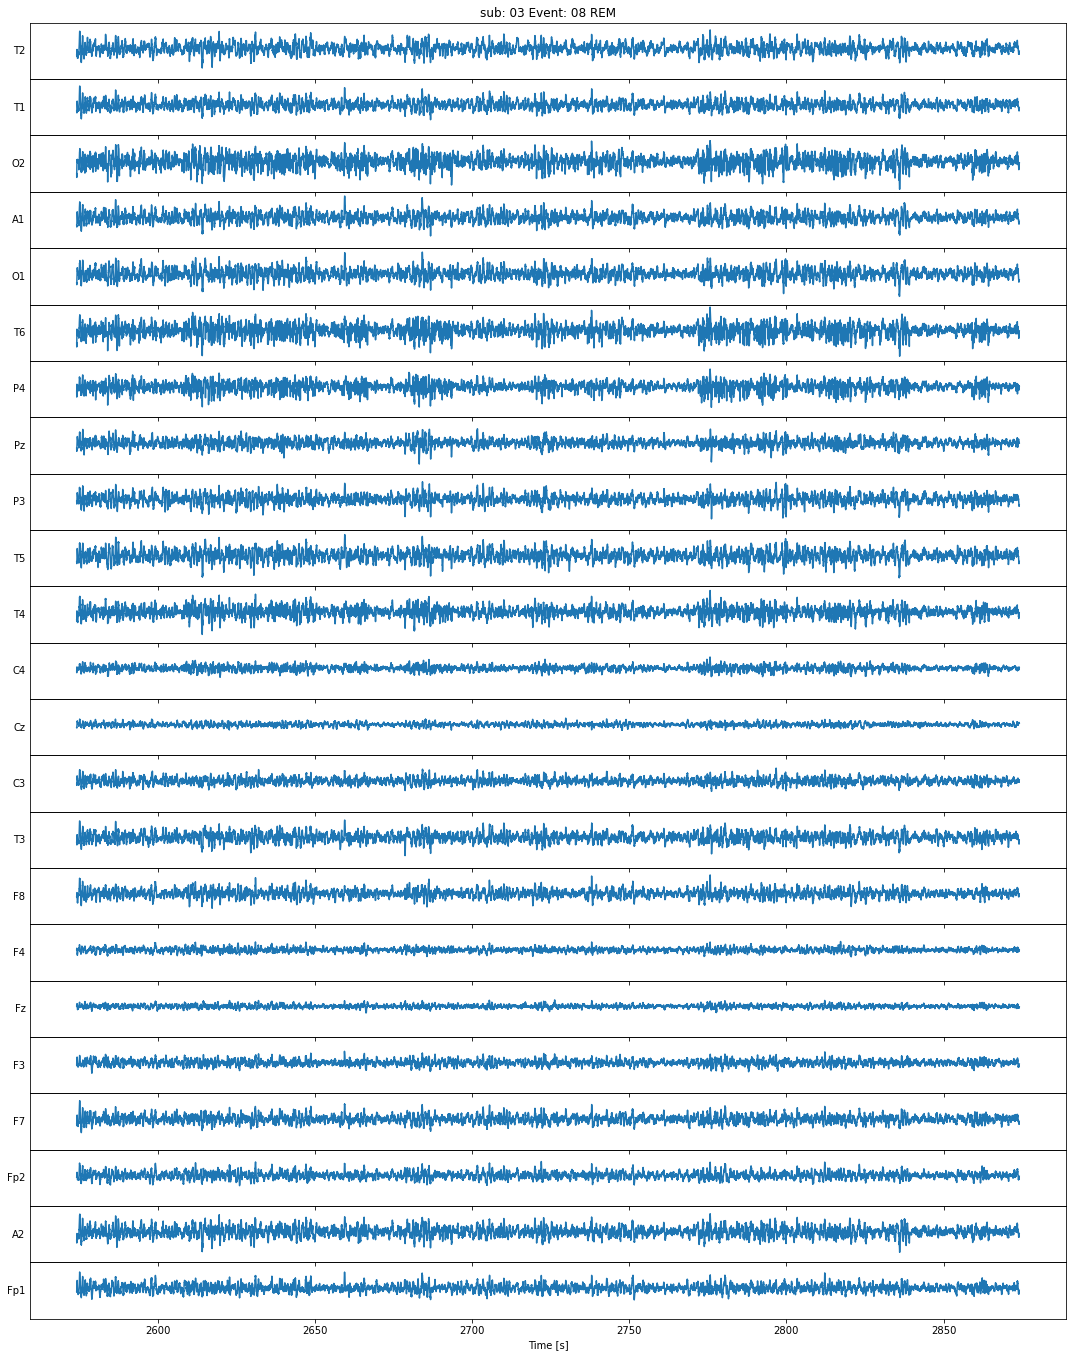

In [23]:
i_i=i_s
i_f=i_e
fig=plt.figure(figsize=(18,18))
count=0.0
axlist = []
yprops = dict(rotation=0, horizontalalignment='right', verticalalignment='center')
axprops = dict(yticks=[])
for i in range(0,n):
    ax = fig.add_axes([0.1, count, 0.8, 1/n], **axprops)
    axlist.append(ax)
    axprops['sharex'] = ax
    axprops['sharey'] = ax
    ax.plot(time_arr[i_i:i_f],data[i,i_i:i_f])
    ax.set_ylabel(chan[i], **yprops)
    count+=1/n
    if i==0:
        plt.xlabel("Time [s]")
for ax in axlist[1:]:
    plt.setp(ax.get_xticklabels(), visible=False)
plt.title("sub: "+sub+" Event: 08 REM")
plt.show();

In [24]:
true_events=events[events["EvPassRejection"]==1]

### Dividing the run in segments

In [25]:
#First we calculate the number of 15s windows in the measurment
window_l=15

windows=int(tf/window_l)

For the first test we will compute the area under the curve(which corresponds to the relative band energy of the segment for a specific chanel in a specific segment), the mean amplitude for each band, the frequency at which the SPD of a band reaches a maximum and the frequency at which the SPD of a band reaches a minimum. These parameter should be able to characterise the shape of the SPD. 

In total we would have 23 chanels, each with 5 frequency bands(delta, theta, alpha, beta and gamma), each with 4 parameters. This means each segment has 460 parameters that describe the funcion.

In [26]:
waves=np.zeros([n,windows,5,4])
for i in range(0,windows):
    for j in range(0,n):
        #Calculate the fft of the ith segment from the nth chanel of the data 
        data_fft=np.absolute(np.fft.rfftn(data[j,i*window_l*fs:(i+1)*window_l*fs]))
        
        #Delta waves: 0.2-4 Hz
        waves[j,i,0,0]=sum(data_fft[:4*window_l])
        waves[j,i,0,1]=np.mean(data_fft[:4*window_l])
        waves[j,i,0,2]=0.2+np.argmax(data_fft[:4*window_l])/window_l
        waves[j,i,0,3]=0.2+np.argmin(data_fft[:4*window_l])/window_l

        # Theta waves: 4-8 Hz
        waves[j,i,1,0]=sum(data_fft[4*window_l:8*window_l])
        waves[j,i,1,1]=np.mean(data_fft[4*window_l:8*window_l])
        waves[j,i,1,2]=4+np.argmax(data_fft[4*window_l:8*window_l])/window_l
        waves[j,i,1,3]=4+np.argmin(data_fft[4*window_l:8*window_l])/window_l
        
        # Alpha waves: 8-12 Hz
        waves[j,i,2,0]=sum(data_fft[8*window_l:12*window_l])
        waves[j,i,2,1]=np.mean(data_fft[8*window_l:12*window_l])
        waves[j,i,2,2]=8+np.argmax(data_fft[8*window_l:12*window_l])/window_l
        waves[j,i,2,3]=8+np.argmin(data_fft[8*window_l:12*window_l])/window_l

        # Beta waves: 12-30 Hz
        waves[j,i,3,0]=sum(data_fft[12*window_l:30*window_l])
        waves[j,i,3,1]=np.mean(data_fft[12*window_l:30*window_l])
        waves[j,i,3,2]=12+np.argmax(data_fft[12*window_l:30*window_l])/window_l
        waves[j,i,3,3]=12+np.argmin(data_fft[12*window_l:30*window_l])/window_l

        # Gamma: 30-90 Hz
        waves[j,i,4,0]=sum(data_fft[30*window_l:90*window_l])
        waves[j,i,4,1]=np.mean(data_fft[30*window_l:90*window_l])
        waves[j,i,4,2]=30+np.argmax(data_fft[30*window_l:90*window_l])/window_l
        waves[j,i,4,3]=30+np.argmin(data_fft[30*window_l:90*window_l])/window_l
    

### Relative band energy
To have an idea of how valueable a parameter is, we will plot them with markings of the sleep stages. First we will plot the relative band energy (area under the curve).

In [27]:
bands=["Delta","Theta","Alpha","Beta","Gamma"]

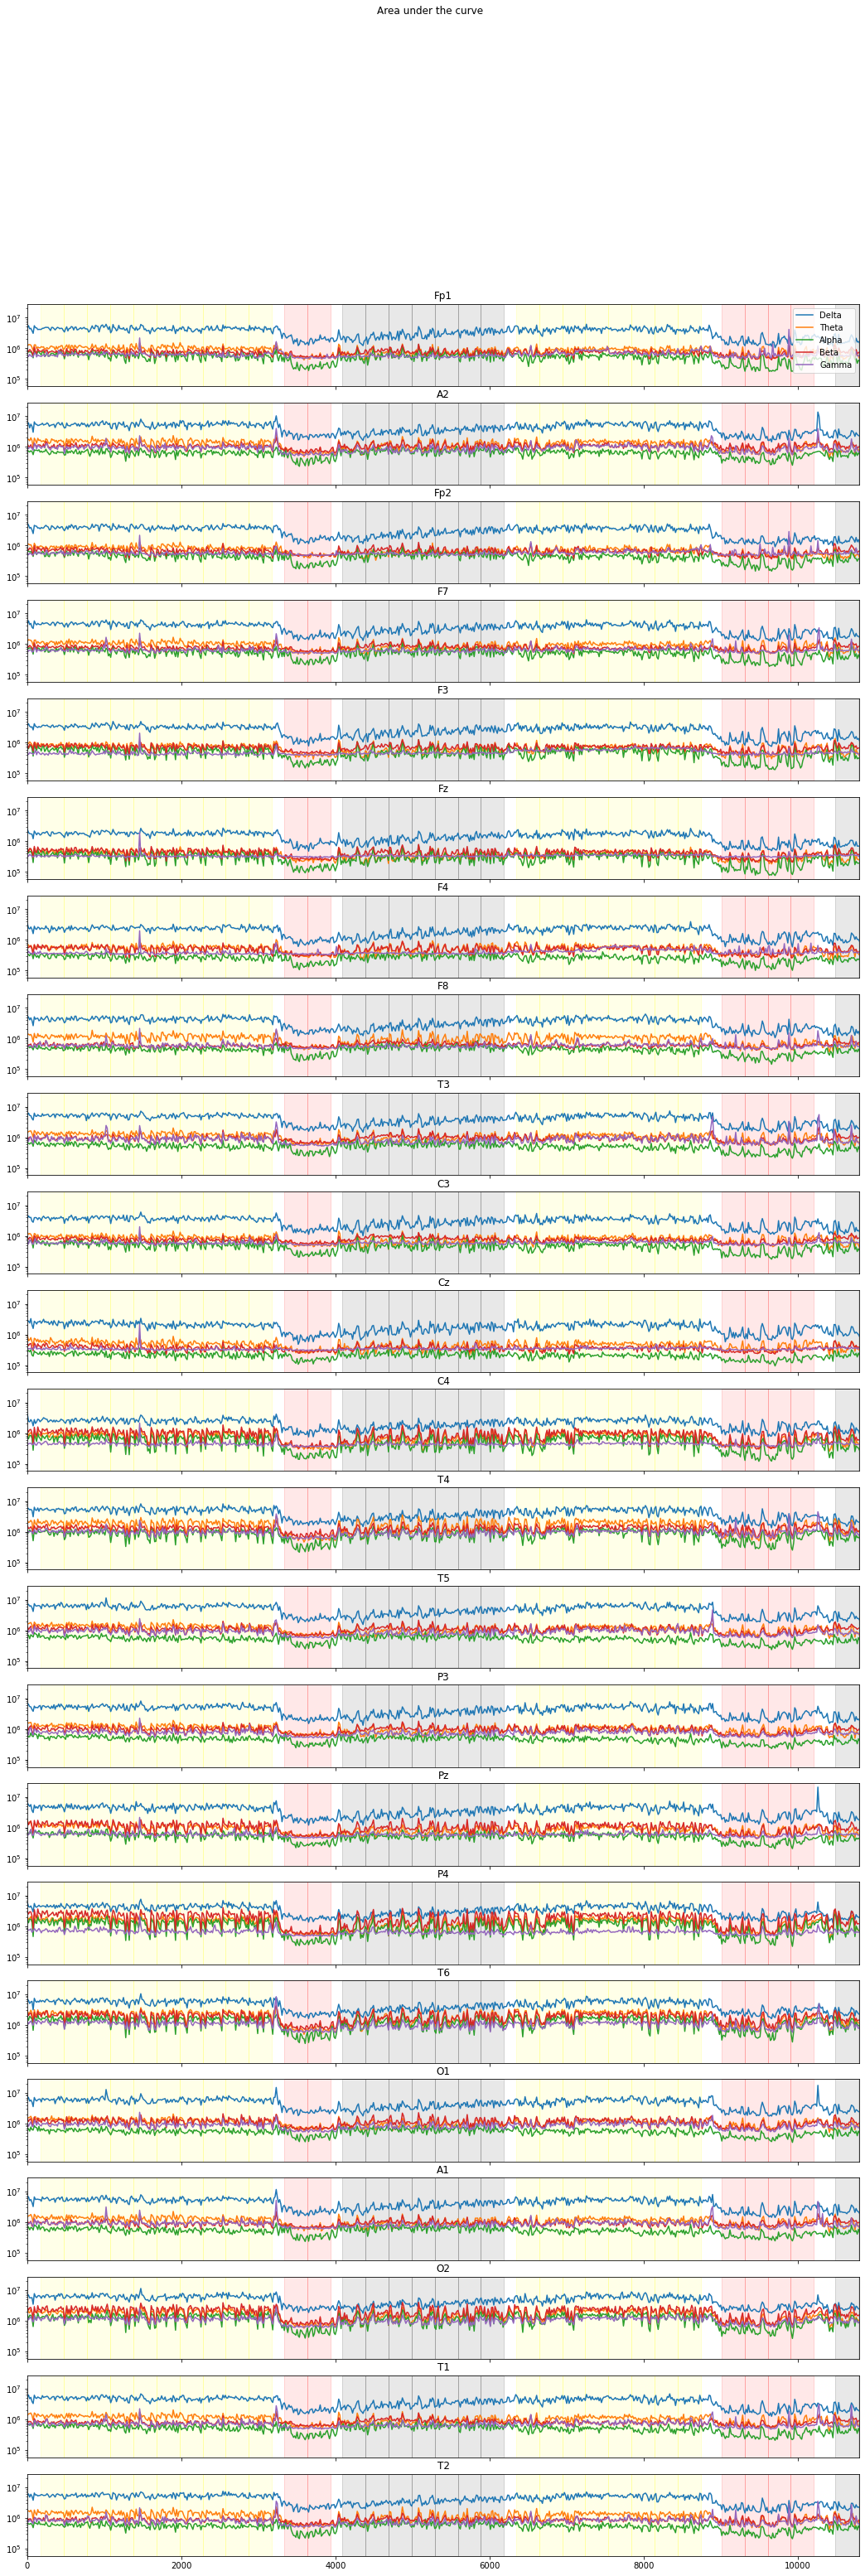

In [50]:
fig, axs = plt.subplots(nrows=n, ncols=1, sharex=True, sharey=True, figsize=(18,50))
for i in range(0,n):
    for j in range(0,5):
        axs[i].plot(np.linspace(0,tf,windows),waves[i,:,j,0],label=bands[j])
    axs[i].set_title(chan[i])
    #ax.set_ylabel(signal_labels[i], **yprops)
    plt.semilogy()
    #plt.ylim(0,4e6)
    plt.xlim(0,tf)
    if i==n:
        axs[i].set_xlabel('Frequency [Hz]')
    for k in range(0,len(intervals)):
        if intervals.iloc[k]["SleepStage"]!="Awake":
            if intervals.iloc[k]["SleepStage"]=="N2":
                color="green"
            if intervals.iloc[k]["SleepStage"]=="N3":
                color="yellow"
            if intervals.iloc[k]["SleepStage"]=="REM":
                color="red"
            [l.axvspan(time_arr[intervals.iloc[k]["StartInd"]],time_arr[intervals.iloc[k]["EndInd"]],color=color,alpha=0.005) for l in axs]
fig.suptitle("Area under the curve")
axs[0].legend()
plt.show;

## Welch plots

Now we will make Welch plots for all of the chanels. This information will provide information about the spectral composition of each chanel. Which might give us an idea to later define usefull paramteters. If we can describe the shape of the welch plot with numbers, we might be able to diferentiate each sleep stage. 

In [30]:
subjects.iloc[int(sub)-1]

participant_id                           sub-03
age                                         4.8
sex                                           m
pathology         (radiologic suspicion of) FCD
eeg_montage                        10-20 system
Name: 2, dtype: object

In [31]:
i_s=intervals[intervals["RunNb"]==int(run)].iloc[0]["StartInd"]
i_e=intervals[intervals["RunNb"]==int(run)].iloc[0]["EndInd"]

In [32]:
data_01=data[:,i_s:i_e]

In [33]:
def Welch(data_NREM,sf):
    win = int(5 * sf)  # Window size is set to 5 seconds
    freqs, psd = welch(data_NREM, sf, nperseg=win, average='median')  # Works with single or multi-channel data

    fig, axs = plt.subplots(nrows=int(np.ceil(len(chan)/2)), ncols=2, sharex=True, sharey=True, figsize=(18,int(2.3*len(chan))))
    for i in range(0,len(chan)):
        row=int(i/2)
        col=i%2

        # Plot
        axs[row, col].plot(freqs, psd[i], 'k', lw=2)
        axs[row, col].fill_between(freqs, psd[i], cmap='Spectral')
        axs[row, col].set_xlim(0, 90)
        axs[row, col].set_ylim(10e-3,10e3)
        axs[row, col].set_yscale('log')
        axs[row, col].set_title(chan[i])
        if row==int(np.ceil(len(chan)/2))-1:
            axs[row, col].set_xlabel('Frequency [Hz]')
        if col==0:
            axs[row, col].set_ylabel('PSD log($uV^2$/Hz)')
    #fig.suptitle("Welch plots")

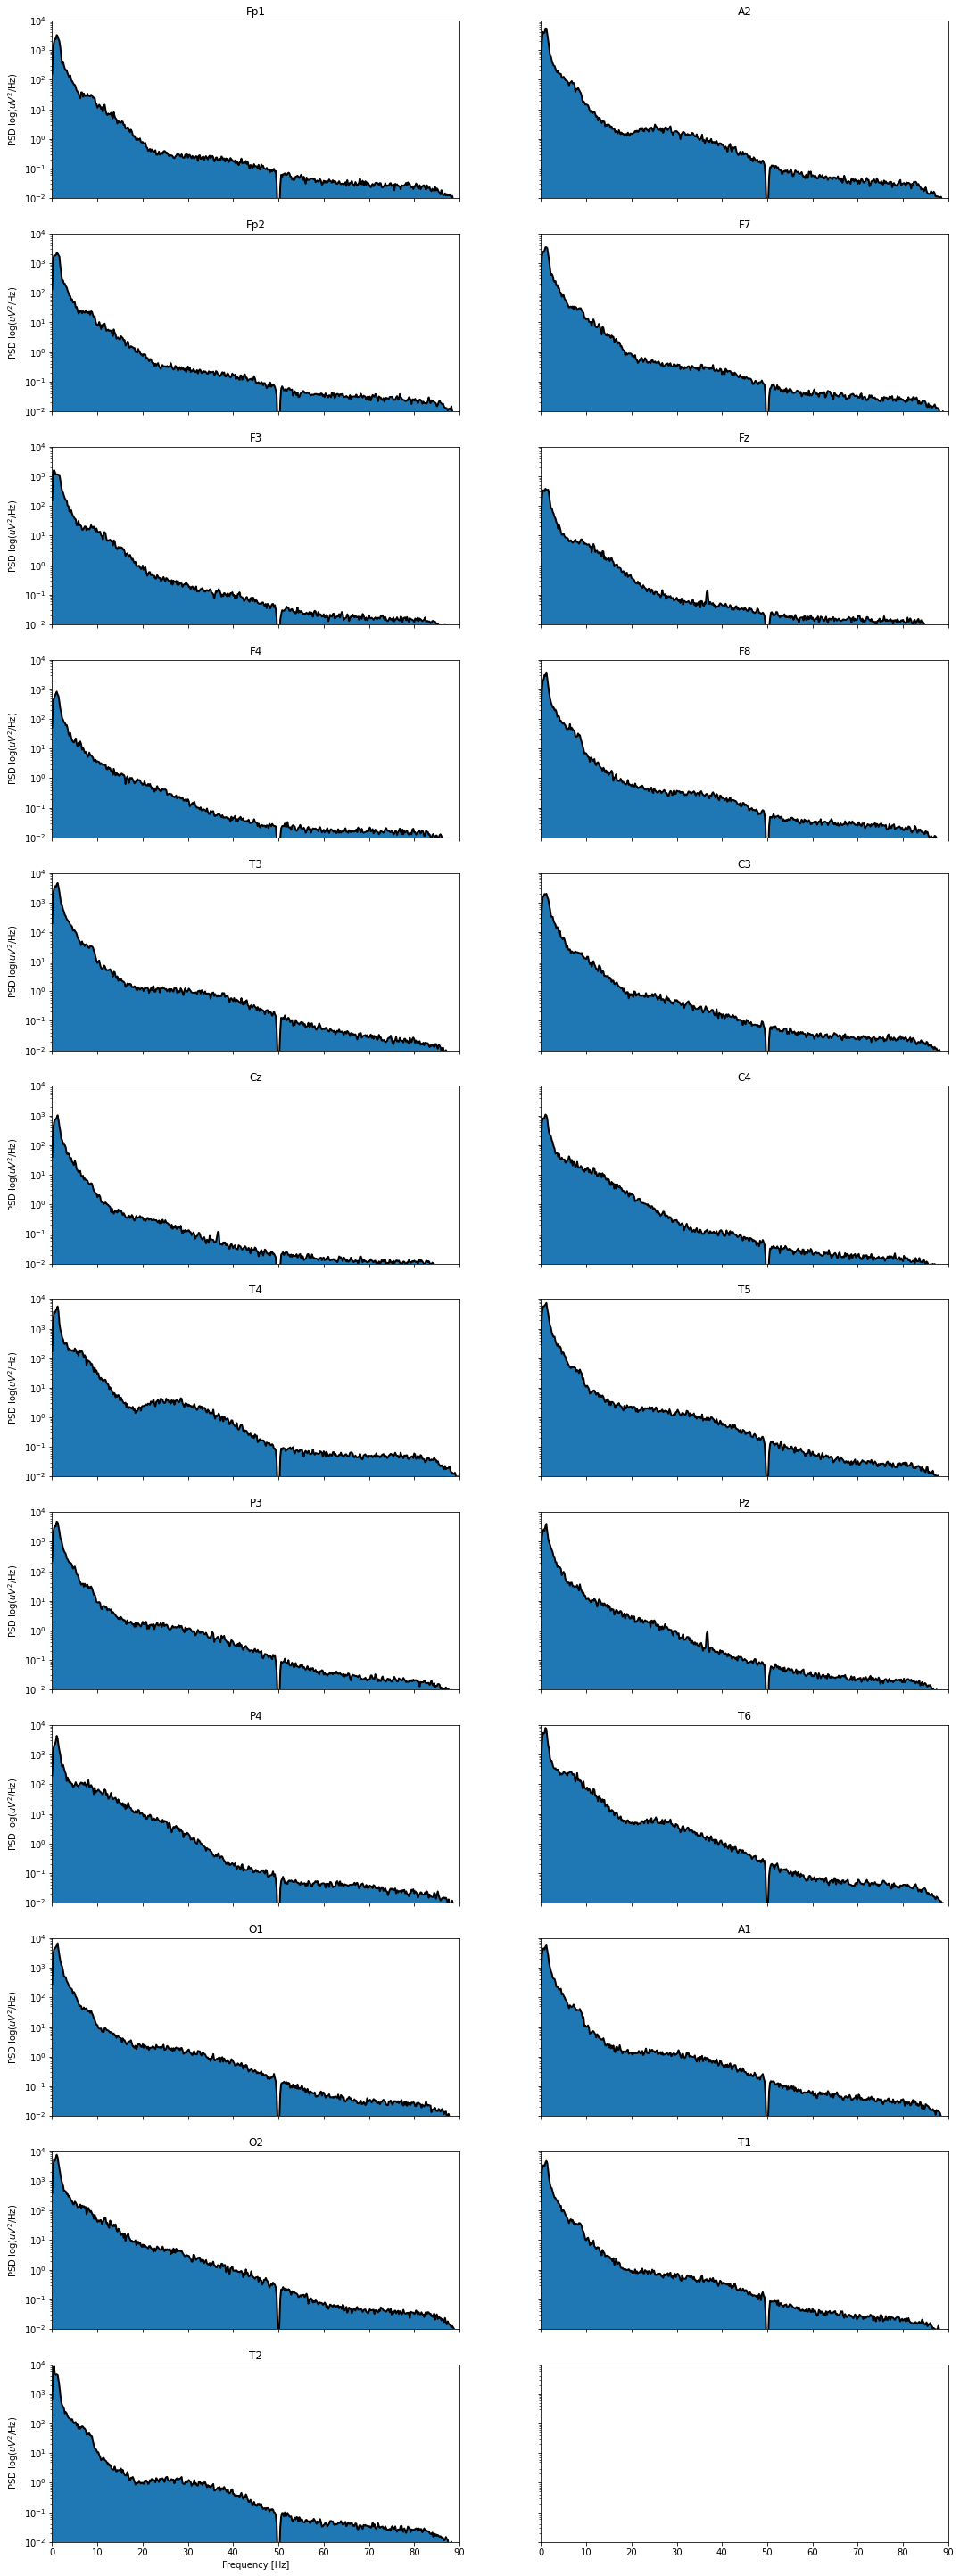

In [34]:
Welch(data_01,fs)

As you might have noticed, some of the plots are biphasic (T2 for example) or even triphasic(T4 and T6). In this case the average or the median of the plot don't describe the welch plot. There are several ways to fix this. The first is to divide the welch plots in diferent bands of predefined lenght like we did in the first analysis. The area under the curve for each band will be enough to identify the phasicity of the curve if the width of each phase matches the band. Another method could be to divide the area under the curve in relative proportions. This would mean we would place markers when the area under the curve reaches 1/5 of the total area, another when it reaches 2/5 and so on. For each marker we would have a frequency and a relative intensity. All of this options will be explored in the next notebook.

## Derivative channels

In the source of the data we are using there is a folder named "derivatives". This file contains bipolar derivations of the original data. This derivations were obtained by a resampling of the data. The are also files of marked events within the bipolar derivation. Now we will try to obtain the same information as before but with this new channels.

The bipolar derivations used correspond to the "double banana" derivations. In this derivation 5 main antero-posterior chains of electrodes are created forming the shape of a double banana. By ploting this bipolar derivations we are able to watch the flow of current though the brain. Sometimes two adjasent links of a chain of electrodes have a similar spike but inverted. This type of phenomenon is called a phase reversal and is very useful in detection of epilepiform activity and artifact detection. 

![](Double_Banana.png)

In [35]:
der_bi_chan=["Fp1-F7","F7-T3","T3-T5","T5-O1","Fp1-F3","F3-C3","C3-P3","P3-O1","Fz-Cz","Cz-Pz","Fp2-F4","F4-C4"
                 ,"C4-P4","P4-O2","Fp2-F8","F8-T4","T4-T6","T6-O2", "F7-T1","T1-T3","F8-T2","T2-T4"]

In [36]:
der_bi_ind=np.zeros([len(der_bi_chan),2],dtype=int)
for i in range(0,len(der_bi_chan)):
    der_bi_ind[i,0]=int(chan.index(der_bi_chan[i].split("-")[0]))
    der_bi_ind[i,1]=int(chan.index(der_bi_chan[i].split("-")[1]))

In [37]:
data_bi=np.zeros([len(der_bi_chan),len(data[0])])
for i in range(0,len(der_bi_chan)):
    data_bi[i]=data[der_bi_ind[i,0]]-data[der_bi_ind[i,1]]

### Plot of derivative chanels

In [38]:
event=8
i_s=intervals.iloc[event]["StartInd"]
i_e=intervals.iloc[event]["EndInd"]

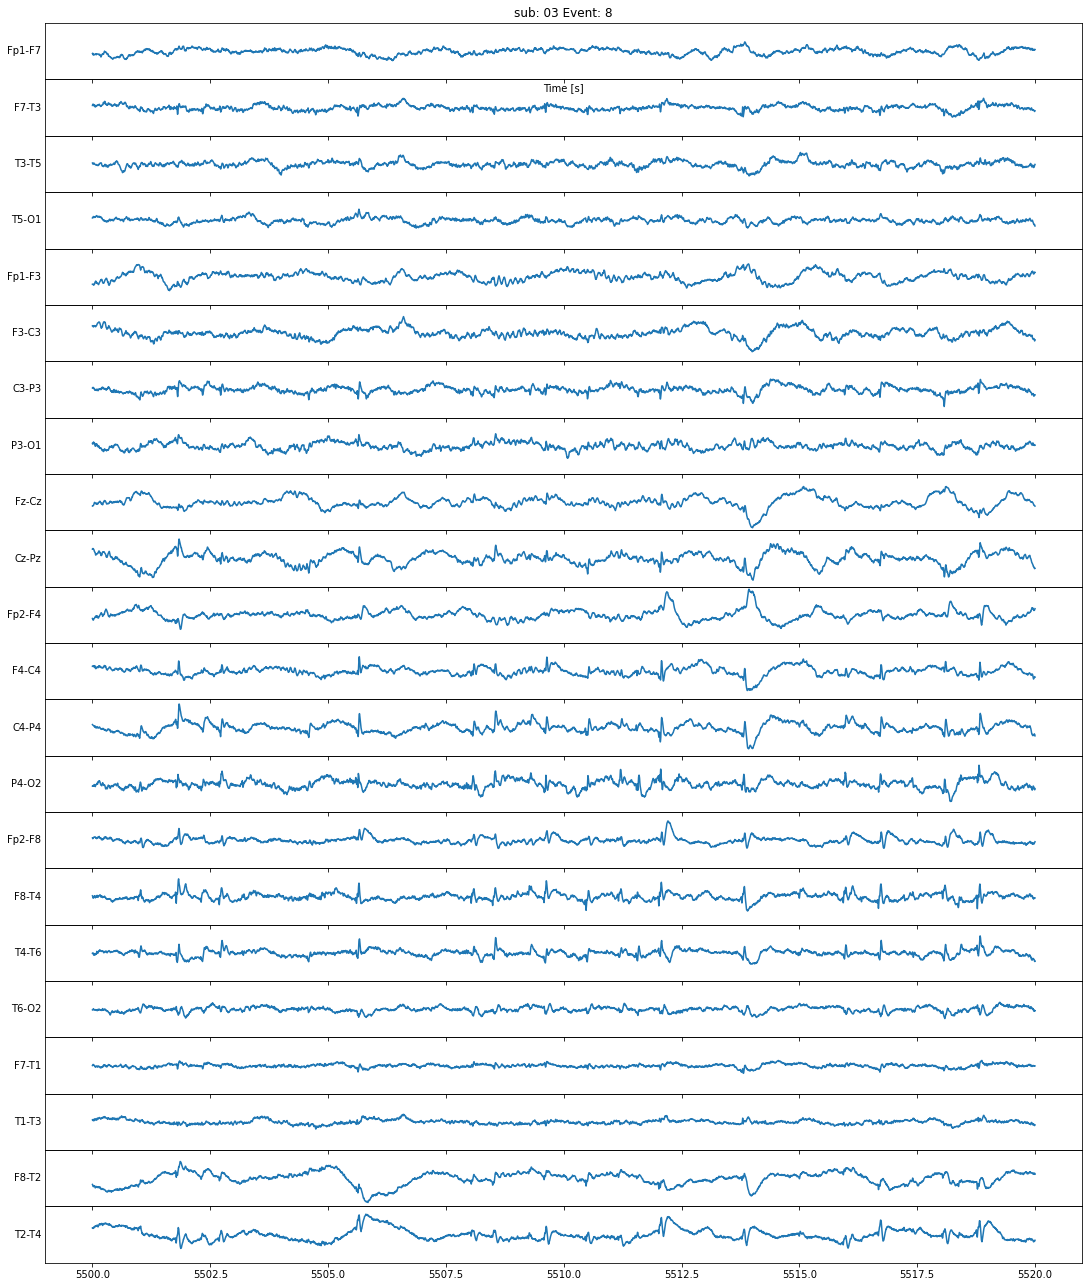

In [64]:
i_i=5500*fs
i_f=5520*fs
fig=plt.figure(figsize=(18,18))
count=0.0
axlist = []
yprops = dict(rotation=0, horizontalalignment='right', verticalalignment='center')
axprops = dict(yticks=[])
for i in range(len(data_bi)-1,-1,-1):
    ax = fig.add_axes([0.1, count, 0.8, 1/n], **axprops)
    axlist.append(ax)
    axprops['sharex'] = ax
    axprops['sharey'] = ax
    ax.plot(time_arr[i_i:i_f],data_bi[i,i_i:i_f])
    ax.set_ylabel(der_bi_chan[i], **yprops)
    count+=1/n
    if i==0:
        plt.xlabel("Time [s]")
for ax in axlist[1:]:
    plt.setp(ax.get_xticklabels(), visible=False)
plt.title("sub: "+sub+" Event: "+str(event))
plt.show();

### Properties of derivative chanels

For the deriatives we will obtain the relative band energy, the mean intensity of the PSD and the frequency at which the median is found. 

In [40]:
waves_bi=np.zeros([len(data_bi),windows,5,3])
for i in range(0,windows):
    for j in range(0,len(data_bi)):
        data_fft=np.absolute(np.fft.rfftn(data_bi[j,i*window_l*fs:(i+1)*window_l*fs]))
        
        #Delta waves: 0.2-4 Hz
        waves_bi[j,i,0,0]=sum(data_fft[:4*window_l])
        waves_bi[j,i,0,1]=np.mean(data_fft[:4*window_l])
        k=0
        temp=0
        while temp<waves_bi[j,i,0,0]/2:
            temp+=data_fft[k]
            k+=1
        waves_bi[j,i,0,2]=k/window_l
        
        # Theta waves: 4-8 Hz
        waves_bi[j,i,1,0]=sum(data_fft[4*window_l:8*window_l])
        waves_bi[j,i,1,1]=np.mean(data_fft[4*window_l:8*window_l])
        k=0
        temp=0
        while temp<waves_bi[j,i,1,0]/2:
            temp+=data_fft[k]
            k+=1
        waves_bi[j,i,1,2]=k/window_l
        
        # Alpha waves: 8-12 Hz
        waves_bi[j,i,2,0]=sum(data_fft[8*window_l:12*window_l])
        waves_bi[j,i,2,1]=np.mean(data_fft[8*window_l:12*window_l])
        k=0
        temp=0
        while temp<waves_bi[j,i,2,0]/2:
            temp+=data_fft[k]
            k+=1
        waves_bi[j,i,2,2]=k/window_l

        # Beta waves: 12-30 Hz
        waves_bi[j,i,3,0]=sum(data_fft[12*window_l:30*window_l])
        waves_bi[j,i,3,1]=np.mean(data_fft[12*window_l:30*window_l])
        k=0
        temp=0
        while temp<waves_bi[j,i,3,0]/2:
            temp+=data_fft[k]
            k+=1
        waves_bi[j,i,3,2]=k/window_l

        # Gamma: 30-90 Hz
        waves_bi[j,i,4,0]=sum(data_fft[30*window_l:90*window_l])
        waves_bi[j,i,4,1]=np.mean(data_fft[30*window_l:90*window_l])
        k=0
        temp=0
        while temp<waves_bi[j,i,4,0]/2:
            temp+=data_fft[k]
            k+=1
        waves_bi[j,i,4,2]=k/window_l

## Results

In [41]:
n_bi=len(data_bi)

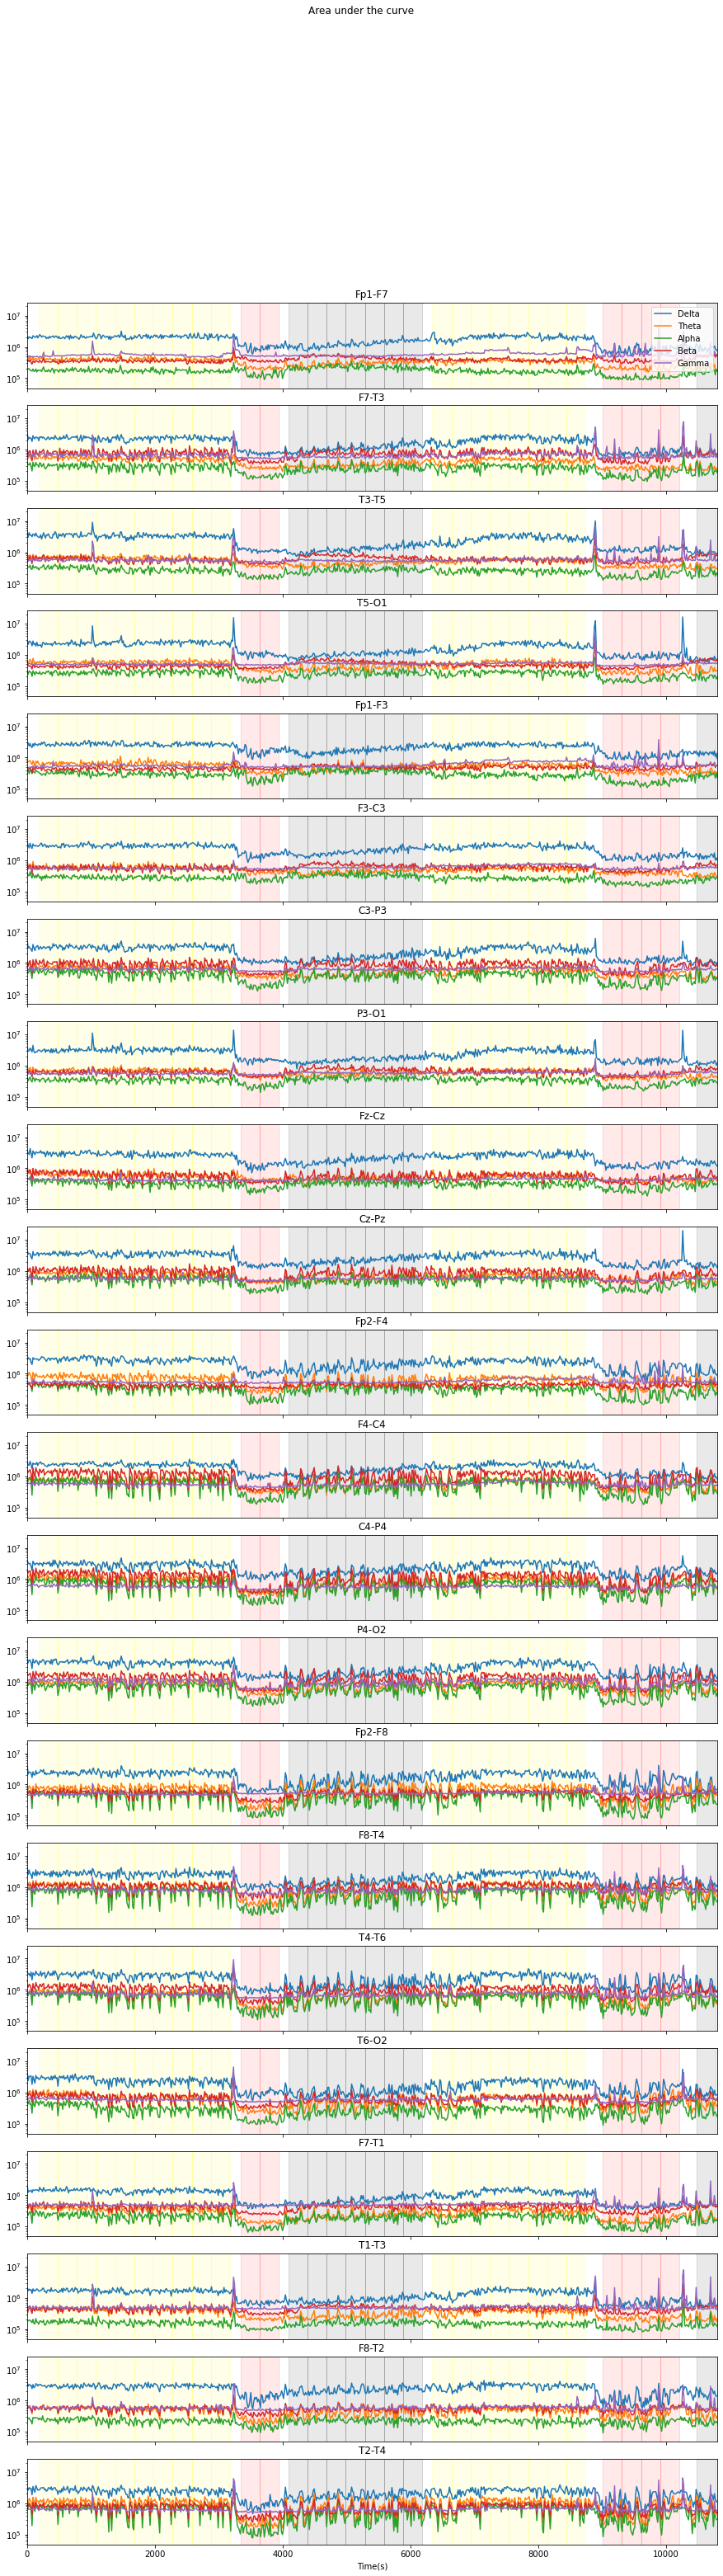

In [66]:
fig, axs = plt.subplots(nrows=n_bi, ncols=1, sharex=True, sharey=True, figsize=(15,50))
for i in range(0,n_bi):
    for j in range(0,5):
        axs[i].plot(np.linspace(0,tf,windows),waves_bi[i,:,j,0],label=bands[j])
    axs[i].set_title(der_bi_chan[i])
    #ax.set_ylabel(signal_labels[i], **yprops)
    #plt.ylim(0,4e6)
    plt.xlim(0,tf)
    plt.semilogy()
    if i==n_bi-1:
        axs[i].set_xlabel('Time(s)')
    for k in range(0,len(intervals)):
        if intervals.iloc[k]["SleepStage"]!="Awake":
            if intervals.iloc[k]["SleepStage"]=="N2":
                color="green"
            if intervals.iloc[k]["SleepStage"]=="N3":
                color="yellow"
            if intervals.iloc[k]["SleepStage"]=="REM":
                color="red"
            [l.axvspan(time_arr[intervals.iloc[k]["StartInd"]],time_arr[intervals.iloc[k]["EndInd"]],color=color,alpha=0.005) for l in axs]
fig.suptitle("Area under the curve")
axs[0].legend()
plt.show;

In the previous plots we can see that there is a drastic difference between the N3 and REM stages, however the difference isn't that big between the other stages. In the N2 stage we can see a high variance in both plots. This might be due to the precence of sleep spindles and k-complexes. 

### Recap of functions:

In [44]:
def segments(sub):
    inter_c=pd.DataFrame({"StartInd":[],"EndInd":[],"SleepStage":[]})
    intervals=pd.read_csv("derivatives/sub-"+sub+"/ses-01/eeg/DataIntervals.tsv",sep="\t")
    start=intervals.iloc[0]["StartInd"]
    stage=intervals.iloc[0]["SleepStage"]
    for i in range(1,len(intervals)):
        if stage!=intervals.iloc[i]["SleepStage"]:
            if intervals.iloc[i-1]["EndInd"]-start>5*60*fs:
                   inter_c.loc[len(inter_c)]=[int(start-150*fs+(intervals.iloc[i-1]["EndInd"]-start)/2),int(start+150*fs+(intervals.iloc[i-1]["EndInd"]-start)/2),stage]
            #inter_c.loc[len(inter_c)]=[int(start),int(intervals.iloc[i-1]["EndInd"]),stage]
            start=intervals.iloc[i]["StartInd"]
            stage=intervals.iloc[i]["SleepStage"]
    if stage==intervals.iloc[-1]["SleepStage"]:
        if intervals.iloc[-1]["EndInd"]-start>5*60*fs:
            inter_c.loc[len(inter_c)]=[int(start-150*fs+(intervals.iloc[-1]["EndInd"]-start)/2),int(start+150*fs+(intervals.iloc[-1]["EndInd"]-start)/2),stage]

    return inter_c

In [45]:
def bipolar_der(sub):
    raw=mne.io.read_raw_edf("sub-"+sub+"/ses-01/eeg/sub-"+sub+"_ses-01_task-hfo_eeg.edf", preload=True, verbose=0)
    raw.filter(0.4, 80)
    raw.notch_filter([50,100])

    data = raw._data
    
    data_bi=np.zeros([len(der_bi_chan),len(data[0])])
    for i in range(0,len(der_bi_chan)):
        data_bi[i]=data[der_bi_ind[i,0]]-data[der_bi_ind[i,1]]
    return data_bi

In [46]:
# data_bi is an array with dimentions of: [bipolar channels, n]
# start is the index in which the segment to be analyzed starts. 
# end is the index in which the segment to be analyzed ends. 
def f_waves(data_bi,start,end):
    #We establish windows of 10s
    window_l=10
    windows=(end-start)/(window_l*fs)
    waves_bi=np.zeros([len(data_bi),windows,5,3])
    for i in range(0,windows):
        for j in range(0,len(data_bi)):
            data_fft=np.absolute(np.fft.rfftn(data_bi[j,start+i*window_l*fs:start+(i+1)*window_l*fs]))

            #Delta waves: 0.2-4 Hz
            waves_bi[j,i,0,0]=sum(data_fft[:4*window_l])
            waves_bi[j,i,0,1]=np.mean(data_fft[:4*window_l])
            k=0
            temp=0
            while temp<waves_bi[j,i,0,0]/2:
                temp+=data_fft[k]
                k+=1
            waves_bi[j,i,0,2]=k/window_l

            # Theta waves: 4-8 Hz
            waves_bi[j,i,1,0]=sum(data_fft[4*window_l:8*window_l])
            waves_bi[j,i,1,1]=np.mean(data_fft[4*window_l:8*window_l])
            k=0
            temp=0
            while temp<waves_bi[j,i,1,0]/2:
                temp+=data_fft[k]
                k+=1
            waves_bi[j,i,1,2]=k/window_l

            # Alpha waves: 8-12 Hz
            waves_bi[j,i,2,0]=sum(data_fft[8*window_l:12*window_l])
            waves_bi[j,i,2,1]=np.mean(data_fft[8*window_l:12*window_l])
            k=0
            temp=0
            while temp<waves_bi[j,i,2,0]/2:
                temp+=data_fft[k]
                k+=1
            waves_bi[j,i,2,2]=k/window_l

            # Beta waves: 12-30 Hz
            waves_bi[j,i,3,0]=sum(data_fft[12*window_l:30*window_l])
            waves_bi[j,i,3,1]=np.mean(data_fft[12*window_l:30*window_l])
            k=0
            temp=0
            while temp<waves_bi[j,i,3,0]/2:
                temp+=data_fft[k]
                k+=1
            waves_bi[j,i,3,2]=k/window_l

            # Gamma: 30-90 Hz
            waves_bi[j,i,4,0]=sum(data_fft[30*window_l:90*window_l])
            waves_bi[j,i,4,1]=np.mean(data_fft[30*window_l:90*window_l])
            k=0
            temp=0
            while temp<waves_bi[j,i,4,0]/2:
                temp+=data_fft[k]
                k+=1
            waves_bi[j,i,4,2]=k/window_l
    
    waves_avg=np.zeros([7,5])
    waves_avg[0]=np.mean(waves_bi[:4,:,:,2],axis=(0,1))
    waves_avg[1]=np.mean(waves_bi[4:8,:,:,2],axis=(0,1))
    waves_avg[2]=np.mean(waves_bi[8:10,:,:,2],axis=(0,1))
    waves_avg[3]=np.mean(waves_bi[10:14,:,:,2],axis=(0,1))
    waves_avg[4]=np.mean(waves_bi[14:18,:,:,2],axis=(0,1))
    waves_avg[5]=np.mean(waves_bi[18:20,:,:,2],axis=(0,1))
    waves_avg[6]=np.mean(waves_bi[20:,:,:,2],axis=(0,1))
    return waves_avg

In [47]:
def data_substarction(data,fs,inter_c):
    for i in range(0,len(inter_c)):
        start=int(inter_c.iloc[i,0]/(15*fs))
        end=int(inter_c.iloc[i,1]/(15*fs))
        

Bibliography:

1. Dorottya Cserpan and Ece Boran and Richard Rosch and San Pietro Lo Biundo and Georgia Ramantani and Johannes Sarnthein (2021). Dataset of EEG recordings of pediatric patients with epilepsy based on the 10-20 system . OpenNeuro. [Dataset] doi: 10.18112/openneuro.ds003555.v1.0.1

2. The Normal Asleep EEG. (2022, July 13). Retrieved from https://www.learningeeg.com/normal-asleep

3. Nayak CS, Anilkumar AC. EEG Normal Sleep. [Updated 2022 May 8]. In: StatPearls [Internet]. Treasure Island (FL): StatPearls Publishing; 2022 Jan-. Available from: https://www.ncbi.nlm.nih.gov/books/NBK537023/

4. Normal Sleep EEG: Overview, Stage I Sleep, Stage II Sleep. (2022, March 11). Retrieved from https://emedicine.medscape.com/article/1140322-overview

5. Diykh, M., & Li, Y. (2016). Complex networks approach for EEG signal sleep stages classification. Expert Syst. Appl., 63, 241–248. doi: 10.1016/j.eswa.2016.07.004

6. Estrada, E., Nazeran, H., Nava, P., Behbehani, K., Burk, J., & Lucas, E. (2004). EEG feature extraction for classification of sleep stages. The 26th Annual International Conference of the IEEE Engineering in Medicine and Biology Society. IEEE. doi: 10.1109/IEMBS.2004.1403125

7. Van Hese, P., Philips, W., De Koninck, J., Van de Walle, R., & Lemahieu, I. (2001). Automatic detection of sleep stages using the EEG. 2001 Conference Proceedings of the 23rd Annual International Conference of the IEEE Engineering in Medicine and Biology Society. IEEE. doi: 10.1109/IEMBS.2001.1020608

8. Diykh, M., & Li, Y. (2016). Complex networks approach for EEG signal sleep stages classification. Expert Syst. Appl., 63, 241–248. doi: 10.1016/j.eswa.2016.07.004